In [8]:
import sys
sys.path.append("d:\python\lib\site-packages")
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from utils.dm import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
config_path = "configs/tsp100.json"
config = get_config(config_path)
#print("Loaded {}:\n{}".format(config_path, config))
dtypeFloat = torch.FloatTensor
dtypeLong = torch.LongTensor
torch.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def train_(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath

    # Load TSP data
    dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean tour lengths
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [10]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    #batch_size = config.batch_size
    #batches_per_epoch = config.batches_per_epoch
    batch_size =10
    batches_per_epoch=10
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=test_filepath)
    #batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

            # Get batch beamsearch tour prediction
            if mode == 'val': 
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test': 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            
            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [11]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    epoch_bar = master_bar(range(1))
    # Training parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    ##train,test,or validation
    for epoch in epoch_bar:
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_(net, optimizer, config, epoch_bar)
        #test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        if epoch % val_every == 0 or epoch == max_epochs-1:
                # Validate
                val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
                # Save checkpoint
                if val_pred_tour_len < best_pred_tour_len:
                    best_pred_tour_len = val_pred_tour_len  # Update best prediction
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                    }, log_dir+"best_val_checkpoint.tar")

                # Update learning rate
                if val_loss > 0.99 * val_loss_old:
                    learning_rate *= decay_rate
                    optimizer = update_learning_rate(optimizer, learning_rate)

                val_loss_old = val_loss  # Update old validation loss

        if epoch % test_every == 0 or epoch == max_epochs-1:
            # Test
            test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        if epoch != 0 and (epoch % 250 == 0 or epoch == max_epochs-1):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, log_dir+f"checkpoint_epoch{epoch}.tar")

        return net

In [12]:
net = main(config)

FileNotFoundError: [Errno 2] No such file or directory: './data/tsp100_train.txt'

tensor([[ 0, 92, 50, 16, 10, 67,  7, 96, 69, 82, 31, 33, 68, 54, 44, 90, 76, 74,
         14, 61, 29, 35, 91, 30, 66, 20, 11, 45, 93, 39, 81, 85, 41, 12,  6, 27,
         17,  3, 80, 70, 55, 83, 15, 78, 32, 99, 13, 75, 94, 79,  1, 56,  4, 95,
         89, 22, 53, 38, 47, 87, 86, 34, 72, 23, 52, 40, 28, 24, 60,  9, 73, 21,
         43, 71, 57,  5, 36, 26, 88, 25, 19, 49, 59, 42, 64, 37, 63, 98, 46,  2,
         65, 18,  8, 97, 62, 48, 77, 58, 84, 51],
        [ 0, 68, 21, 60, 75, 12, 32, 46, 69,  8, 93, 67, 36, 28,  2, 91,  7, 97,
         34, 80, 31, 50, 19, 81, 85, 18, 51, 83, 78, 29,  9, 16, 22, 56, 52, 94,
         53,  4, 38, 89, 57, 62, 10,  5, 39, 45, 14, 17, 44, 40, 33, 79, 61, 59,
         63, 87, 82,  6, 23, 48, 88, 41, 71, 90, 92, 74, 76, 84, 58, 65, 49, 20,
         66, 43, 11, 77, 24, 54, 30,  3, 27, 37, 42, 47, 13, 64, 73, 98, 72, 55,
         70, 35, 15,  1, 96, 99, 26, 86, 25, 95],
        [ 0, 32, 23, 92, 47, 89, 70, 19, 50, 41, 97, 64, 61, 67, 87, 82, 49, 45,
         

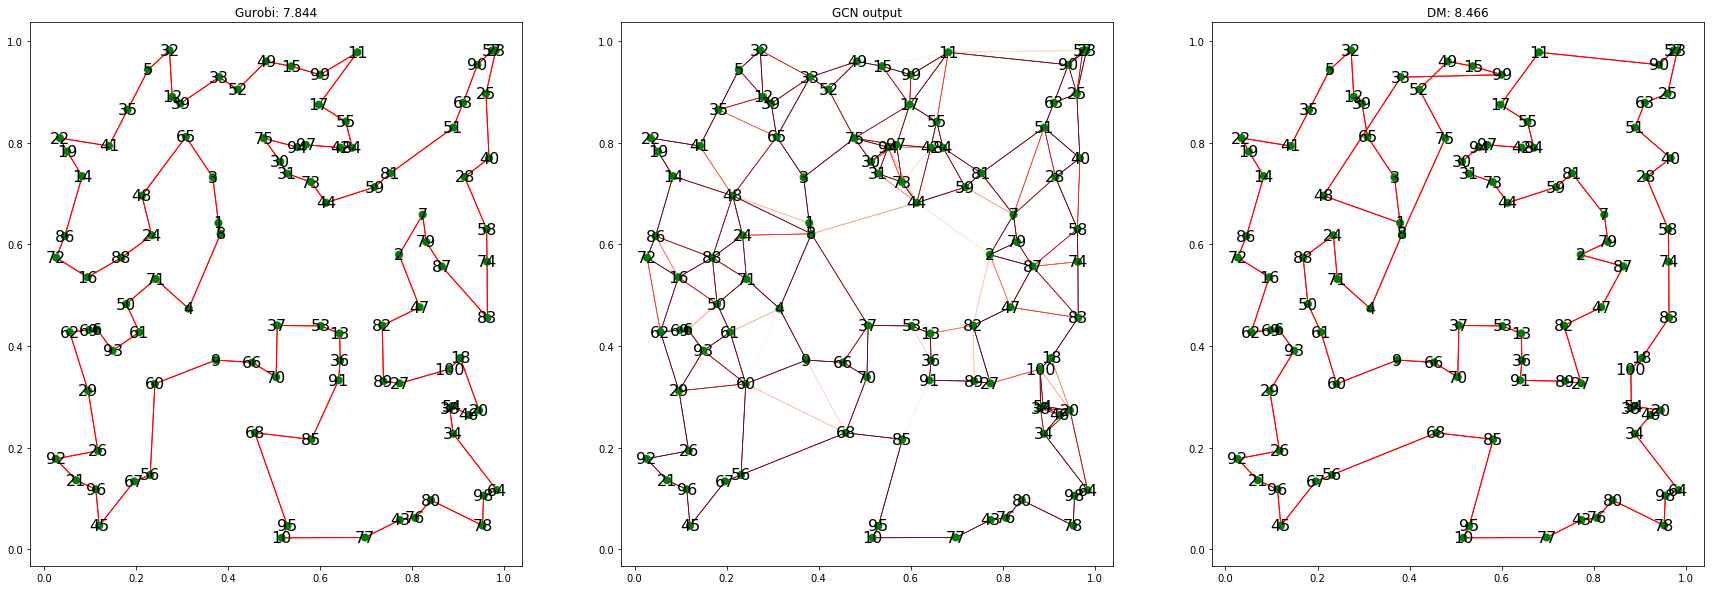

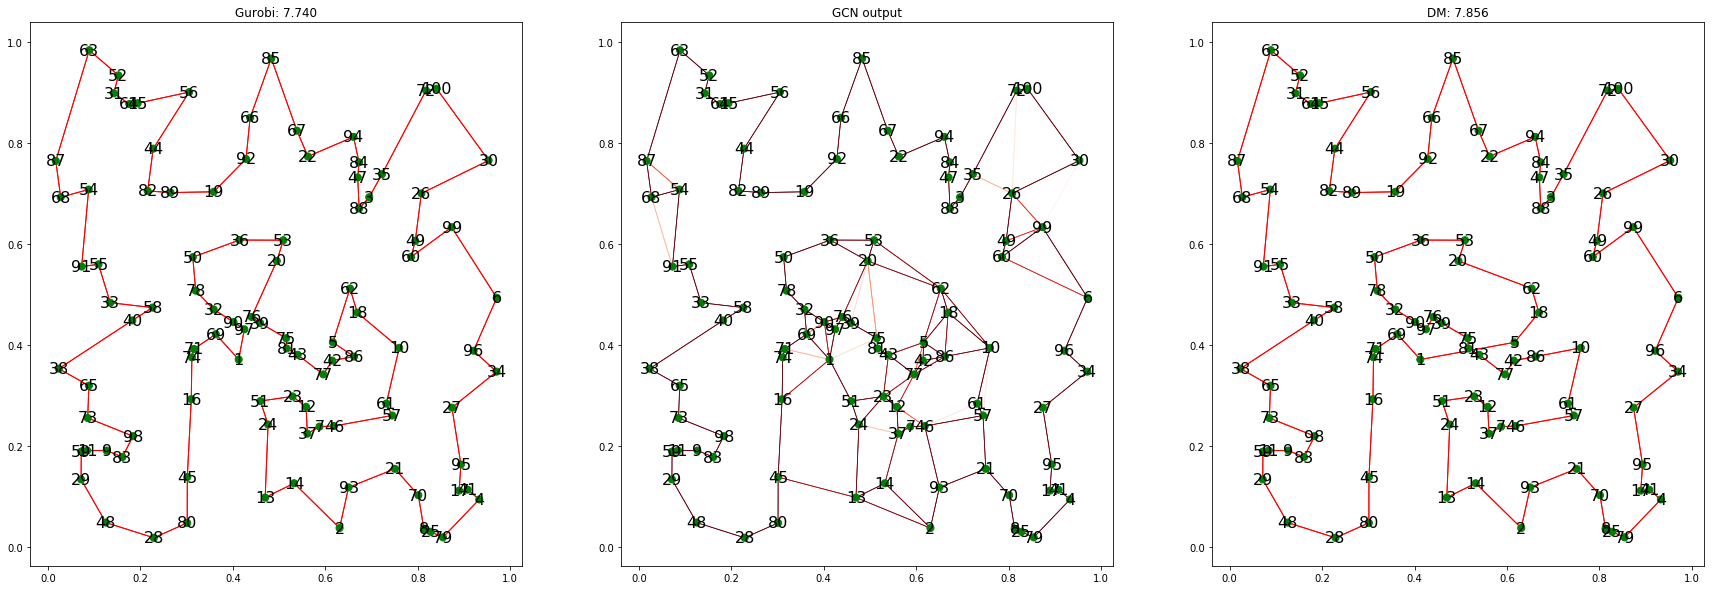

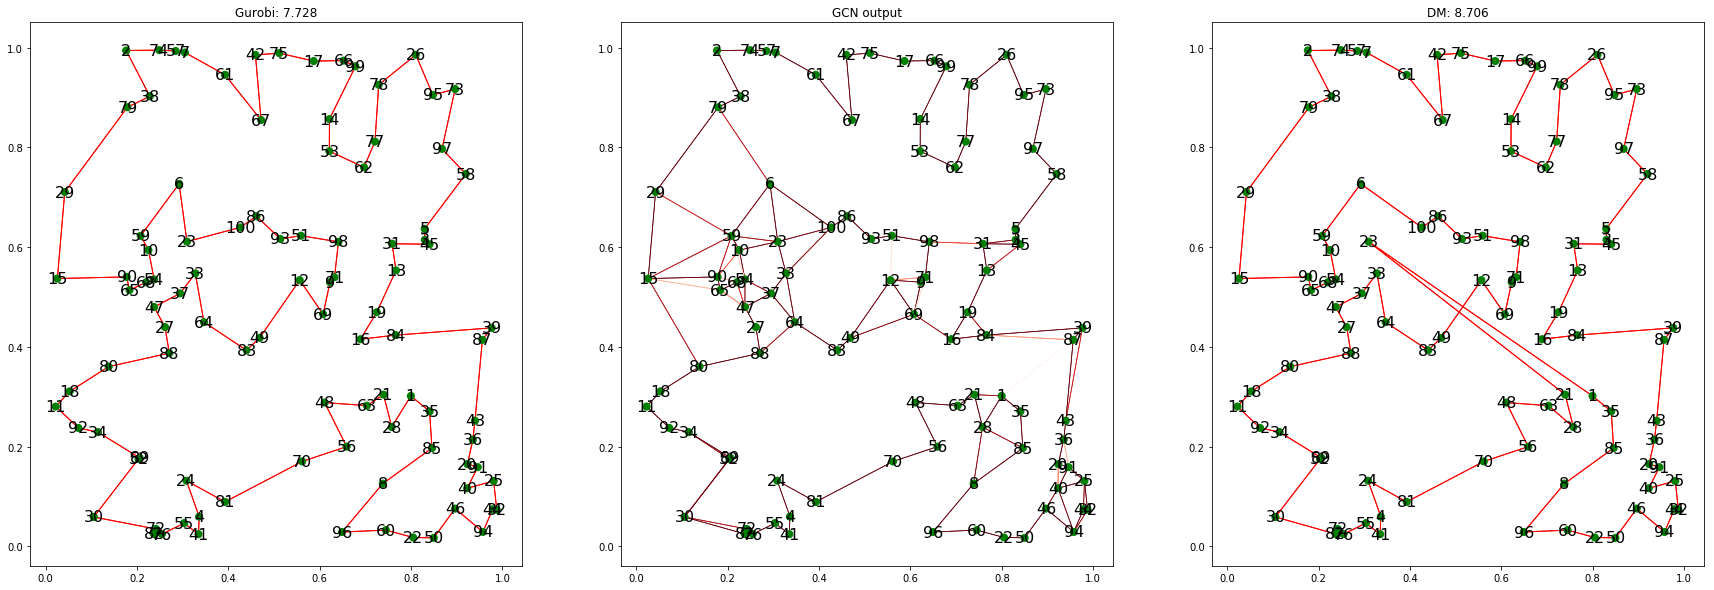

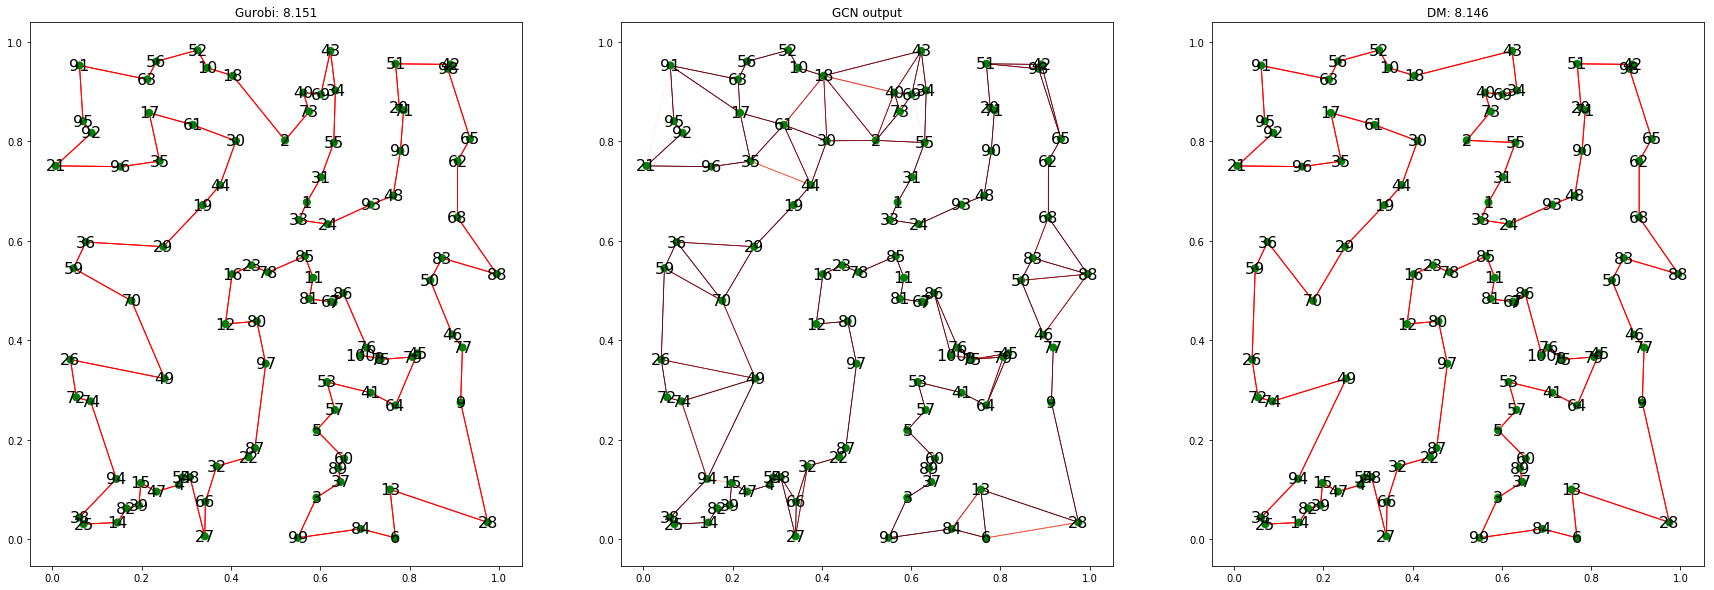

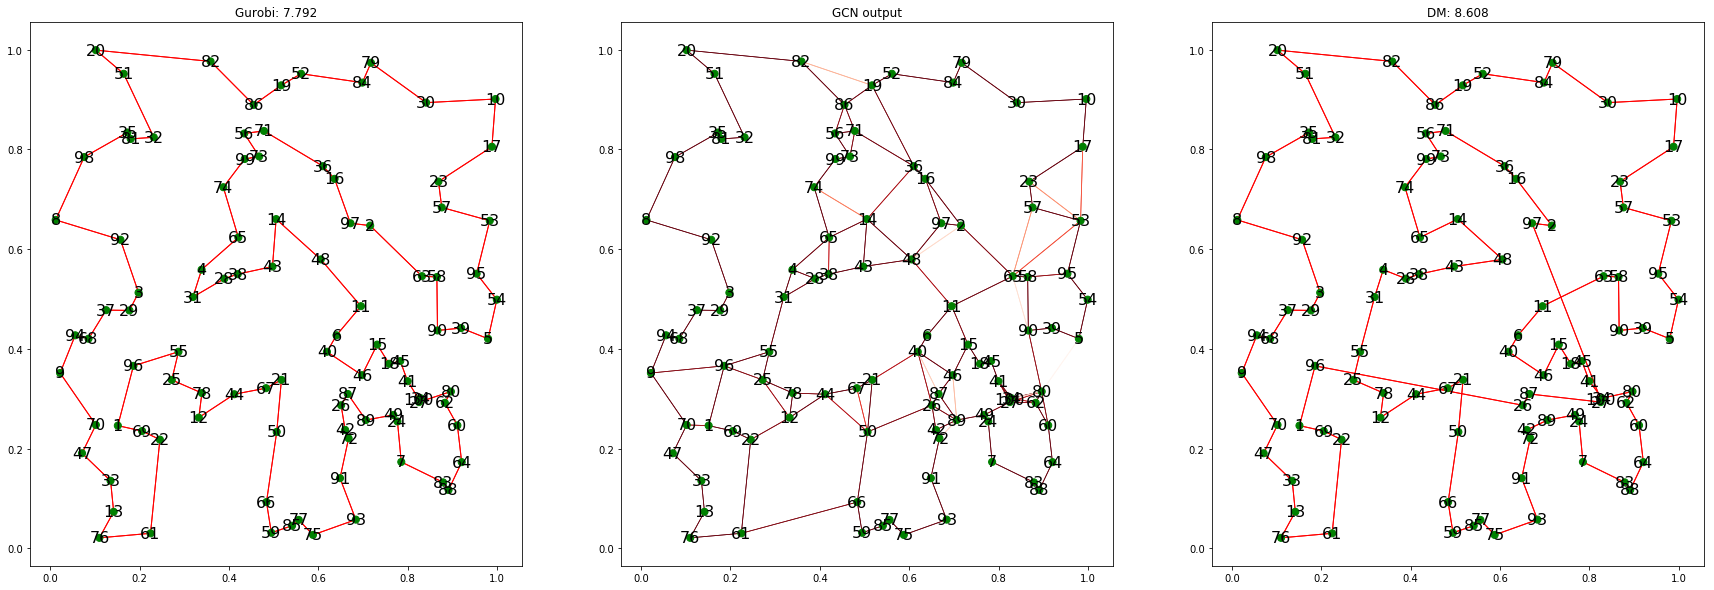

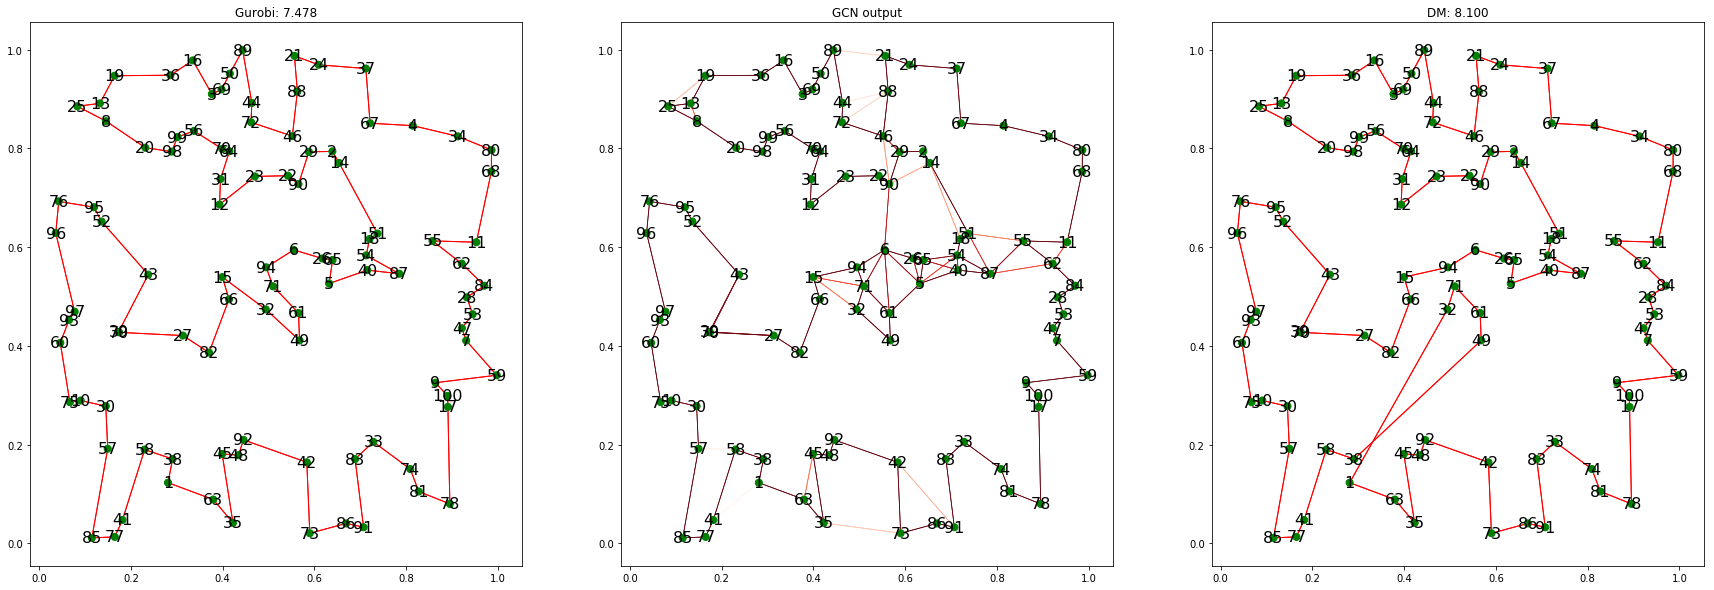

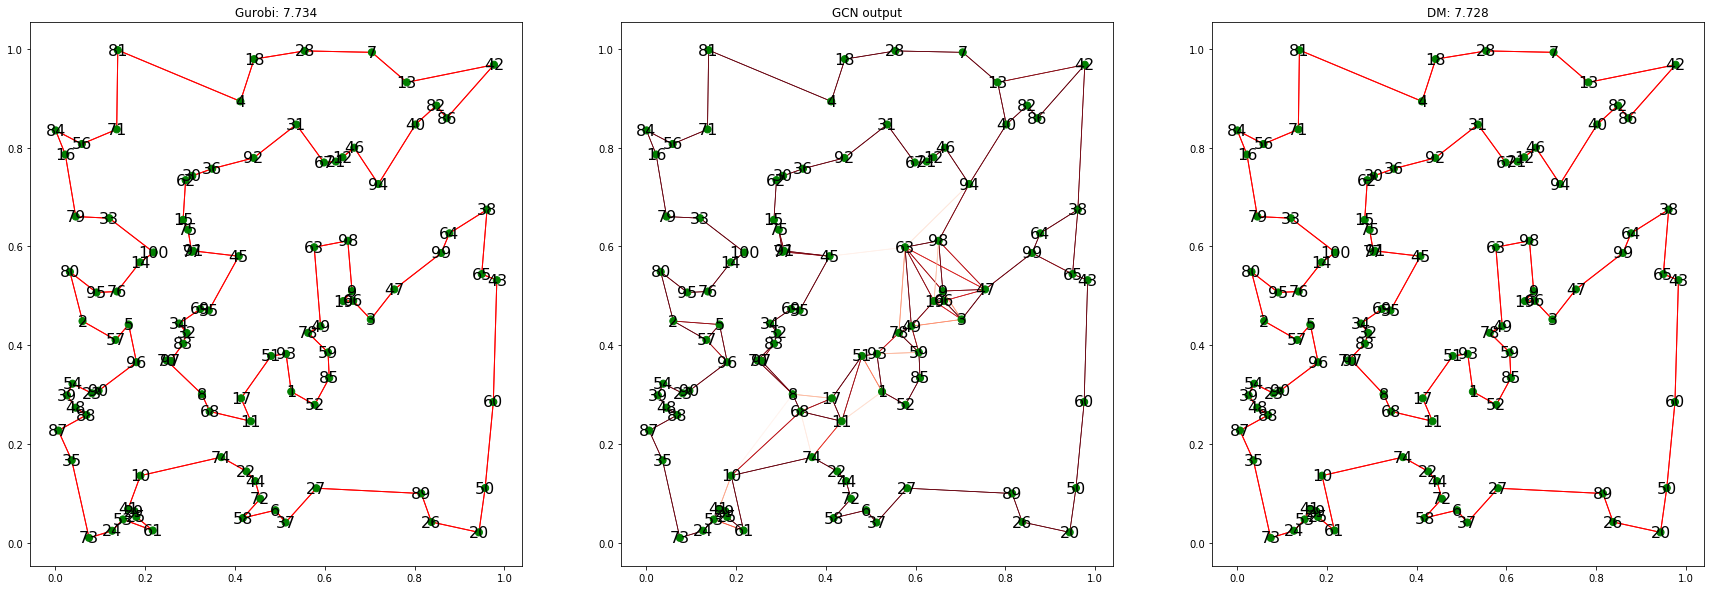

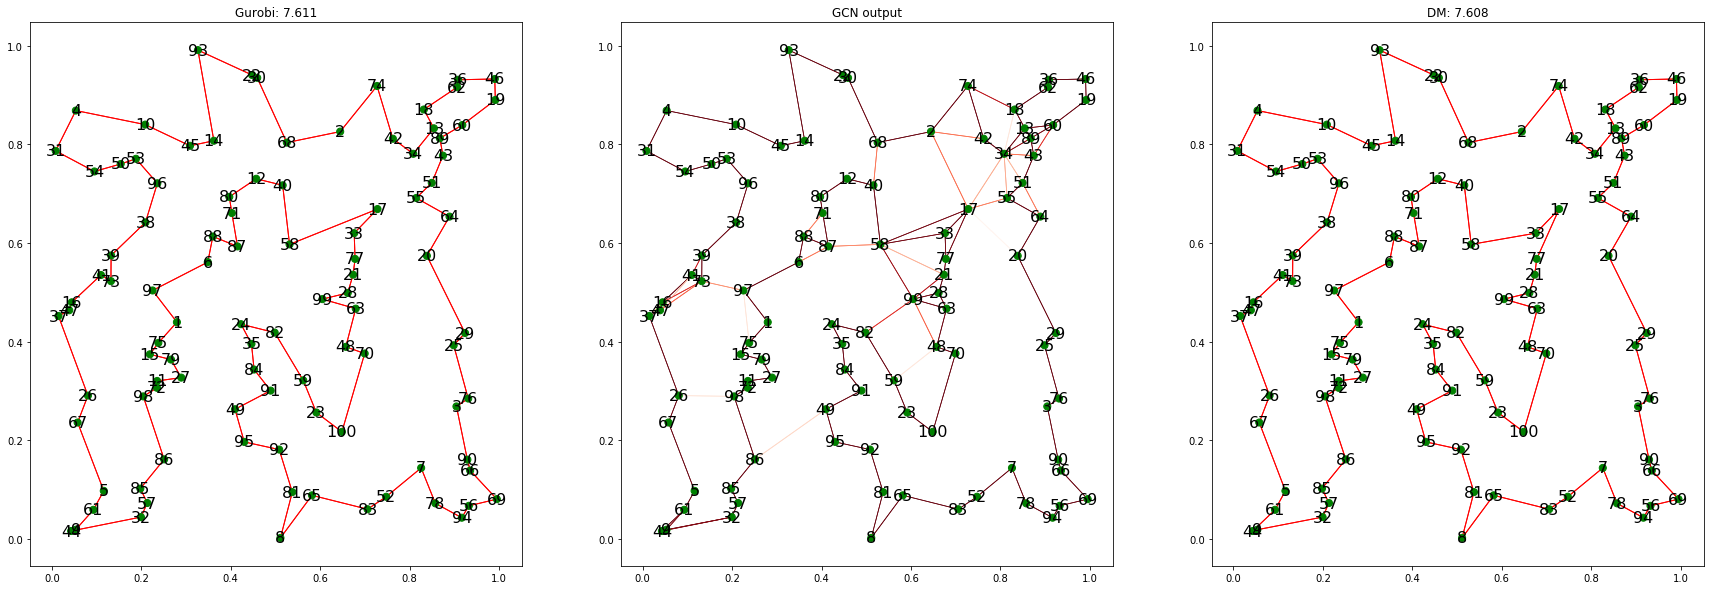

In [166]:
# visualization
net.eval()
batch_size = 10
num_nodes = config.num_nodes
num_neighbors = config.num_neighbors
beam_size = config.beam_size
test_filepath = config.test_filepath
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
batch = next(dataset)
with torch.no_grad():
    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()

    # Get batch beamsearch tour prediction
    config.beam_size =1#then greedy search this is
    bs_nodes = beamsearch_tour_nodes_shortest(
        y_preds, x_edges_values,  beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
    #bs_nodes = beamsearch_tour_nodes(
       # y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
    #bs_nodes=[34,26,20,41,1,6,48,10,2,43,4,46,12,16,3,22,11,49,13,17,15,39,28,35,14,42,5,27,7,18,31,38,19,21,25,33,8,47,37,45,23,29,50,32,24,9,40,36,30,44]
   # bs_nodes=np.array(bs_nodes)
    #bs_nodes=bs_nodes-1
    #bs_nodes=torch.tensor(bs_nodes)
    #bs_nodes=bs_nodes.unsqueeze(0)
    print(bs_nodes)
    # Compute mean tour length
    pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
    gt_tour_len = np.mean(batch.tour_len)
    # Plot prediction visualizations
    plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=batch_size)
    
     # Get batch iterative algorithm tour prediction
    dm_nodes = dm(
        y_preds, x_edges_values, batch_size, num_nodes)
    print(dm_nodes)
    # Compute mean tour length
    pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
    gt_tour_len = np.mean(batch.tour_len)
    # Plot prediction visualizations
    plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=batch_size)

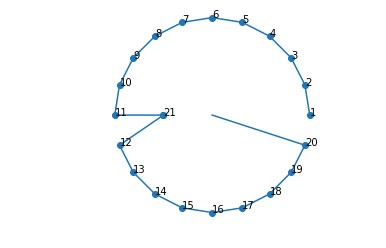

In [28]:
import random
import math
import matplotlib.pyplot as plt


def circle():
    x = [-0.5]
    y = [0]
    for i in range(0,20):
        angle = 0.05*i*(math.pi*2)
        x.append(math.cos(angle));
        y.append(math.sin(angle));
    x.append(-0.5);
    y.append(0);
    x1 = []
    y1 = []
    for i in range(0,20):
        angle = 0.05*i*(math.pi*2)
        x1.append(math.cos(angle));
        y1.append(math.sin(angle));
        if i==10 :
            x1.append(-0.5);
            y1.append(0);    
    x1.append(0);
    y1.append(0);
    labels={}
    for i in range(0,22):
        if i== 0 :
            labels[i]=""
        else :
            labels[i]=str(i)
    plt.scatter(x,y)
    plt.plot(x1,y1)
    for i in range(0,22):
       plt.annotate(labels[i],(x[i],y[i]))
    plt.axis("off")
    plt.axes().set_aspect('equal', 'datalim')
    plt.show()
circle()